In [1]:
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

2024-03-03 22:54:42.908039: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 22:54:42.980187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 22:54:42.980233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 22:54:42.981679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 22:54:42.990587: I tensorflow/core/platform/cpu_feature_guar

In [2]:
batch_size = 100
original_dim = 784 # images are 28x28 pixels
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


In [3]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


2024-03-03 22:55:16.532943: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-03-03 22:55:16.532987: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Server3A6000
2024-03-03 22:55:16.532995: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Server3A6000
2024-03-03 22:55:16.533086: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.54.14
2024-03-03 22:55:16.533108: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.29.6
2024-03-03 22:55:16.533114: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 545.29.6 does not match DSO version 550.54.14 -- cannot find working devices in this configuration


In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


In [5]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)



In [6]:
vae = Model(x, x_decoded_mean)


In [7]:
encoder = Model(x, z_mean)


In [8]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


In [9]:
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) -
K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)


In [10]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                              

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size,
validation_data=(x_test, None))


Epoch 1/50
600/600 [==============================] - 7s 11ms/step - loss: 192.5502 - val_loss: 172.6165
Epoch 2/50
600/600 [==============================] - 6s 10ms/step - loss: 170.5953 - val_loss: 167.3678
Epoch 3/50
600/600 [==============================] - 6s 10ms/step - loss: 166.4335 - val_loss: 164.7676
Epoch 4/50
600/600 [==============================] - 6s 11ms/step - loss: 163.9003 - val_loss: 162.8187
Epoch 5/50
600/600 [==============================] - 6s 10ms/step - loss: 162.0658 - val_loss: 161.0482
Epoch 6/50
600/600 [==============================] - 6s 10ms/step - loss: 160.6004 - val_loss: 160.0685
Epoch 7/50
600/600 [==============================] - 6s 10ms/step - loss: 159.4524 - val_loss: 159.0566
Epoch 8/50
600/600 [==============================] - 6s 9ms/step - loss: 158.4975 - val_loss: 158.4877
Epoch 9/50
600/600 [==============================] - 6s 10ms/step - loss: 157.7226 - val_loss: 157.5846
Epoch 10/50
600/600 [==============================] - 6

100/100 [==============================] - 0s 3ms/step


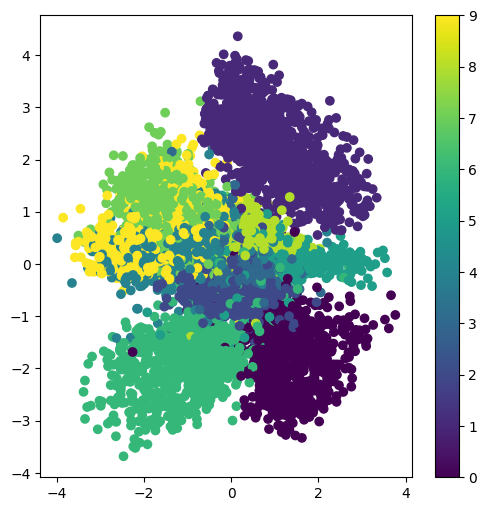

In [14]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 36ms/step


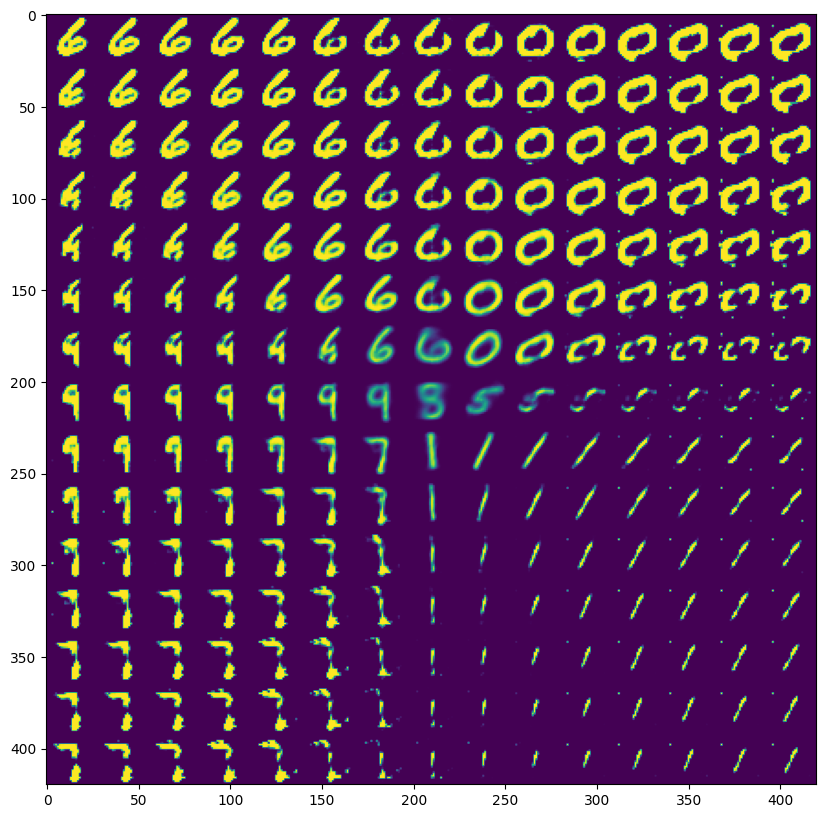

In [15]:
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
